In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler, LabelEncoder # to encode the labels as numeric values

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/neural-net-nexus/sample_submission.csv
/kaggle/input/neural-net-nexus/train.csv
/kaggle/input/neural-net-nexus/test.csv


# Data Preprocessing

In [2]:
df=pd.read_csv("/kaggle/input/neural-net-nexus/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      526 non-null    float64
 1   HB (gm/dl)               529 non-null    float64
 2   ESR(mm)                  529 non-null    float64
 3   WBC(TC) (/cumm)          528 non-null    float64
 4   Neutrophils (%)          529 non-null    int64  
 5   lymphocytes (%)          529 non-null    int64  
 6   Monocytes (%)            527 non-null    float64
 7   Eosinophils (%)          527 non-null    float64
 8   Cir Eosinophils (/cumm)  526 non-null    float64
 9   RBC (m/ul)               527 non-null    float64
 10  HTC/PCV (%)              529 non-null    float64
 11  MCV (fl)                 526 non-null    float64
 12  MCH (pg)                 528 non-null    float64
 13  MCHC (g/dl)              529 non-null    float64
 14  RDW  (%)                 5

## Clearing NULL values

In [3]:
df.isna().sum()


Age                          3
HB (gm/dl)                   0
ESR(mm)                      0
WBC(TC) (/cumm)              1
Neutrophils (%)              0
lymphocytes (%)              0
Monocytes (%)                2
Eosinophils (%)              2
Cir Eosinophils (/cumm)      3
RBC (m/ul)                   2
HTC/PCV (%)                  0
MCV (fl)                     3
MCH (pg)                     1
MCHC (g/dl)                  0
RDW  (%)                     1
PDW (fl)                     0
Platelete(PC)(/cumm)         2
MPV (fl)                     1
PCT (%)                      0
Class Identification         0
Unnamed: 20                529
Unnamed: 21                529
Unnamed: 22                529
Unnamed: 23                529
Unnamed: 24                529
Unnamed: 25                529
dtype: int64

Last 5 columns are unnecessary.So we can drop it.

In [4]:
df=df.drop(["Unnamed: 20","Unnamed: 21","Unnamed: 22","Unnamed: 23","Unnamed: 24","Unnamed: 25"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      526 non-null    float64
 1   HB (gm/dl)               529 non-null    float64
 2   ESR(mm)                  529 non-null    float64
 3   WBC(TC) (/cumm)          528 non-null    float64
 4   Neutrophils (%)          529 non-null    int64  
 5   lymphocytes (%)          529 non-null    int64  
 6   Monocytes (%)            527 non-null    float64
 7   Eosinophils (%)          527 non-null    float64
 8   Cir Eosinophils (/cumm)  526 non-null    float64
 9   RBC (m/ul)               527 non-null    float64
 10  HTC/PCV (%)              529 non-null    float64
 11  MCV (fl)                 526 non-null    float64
 12  MCH (pg)                 528 non-null    float64
 13  MCHC (g/dl)              529 non-null    float64
 14  RDW  (%)                 5

In [5]:
df=df.dropna()
df.isna().sum()

Age                        0
HB (gm/dl)                 0
ESR(mm)                    0
WBC(TC) (/cumm)            0
Neutrophils (%)            0
lymphocytes (%)            0
Monocytes (%)              0
Eosinophils (%)            0
Cir Eosinophils (/cumm)    0
RBC (m/ul)                 0
HTC/PCV (%)                0
MCV (fl)                   0
MCH (pg)                   0
MCHC (g/dl)                0
RDW  (%)                   0
PDW (fl)                   0
Platelete(PC)(/cumm)       0
MPV (fl)                   0
PCT (%)                    0
Class Identification       0
dtype: int64

In [6]:
df["Class Identification"].unique()

array(['Negative', 'Positive', 'Abnormal', 'Normal'], dtype=object)

## Cleaning Output Features

From the above output it is clear that "Class Identification" column contains 4 labels.But we need only 2 labels(Positive and Negative).This can be acheived by changing 'Normal' to 'Negative' and 'Abnormal' to 'Positive'.

In [7]:
# Replace 'Normal' with 'Negative' and 'Abnormal' with 'Positive'
df["Class Identification"] = df["Class Identification"].replace({
    'Normal': 'Negative',
    'Abnormal': 'Positive'
})

# Use LabelEncoder to encode 'Positive' as 1 and 'Negative' as 0
label_encoder = LabelEncoder()
df['Class Identification'] = label_encoder.fit_transform(df['Class Identification'])

# Verify the changes
print(df['Class Identification'].value_counts())

Class Identification
0    370
1    139
Name: count, dtype: int64


## Feature Selection and Scaling

In [8]:
y = df['Class Identification']
x = df.drop(columns=['Class Identification']).values
y.shape


(509,)

In [9]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Training the Model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_train, X_val, y_train, y_val = train_test_split(x_scaled, y, test_size=0.2, random_state=42)


## SVM

In [11]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [12]:
model=svm.SVC(class_weight="balanced",kernel='rbf')
model.fit(X_train,y_train)
print(roc_auc_score(y_val,model.predict(X_val)))

0.7801133679735474


## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
model_1=LogisticRegression(class_weight="balanced")
model_1.fit(X_train,y_train)

#y_prob = model.predict_proba(X_val)[:, 1]
print(roc_auc_score(y_val,model_1.predict(X_val)))

0.6905999055266887


## Neural Network

In [15]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True, 
    min_delta = 0.0001 
)

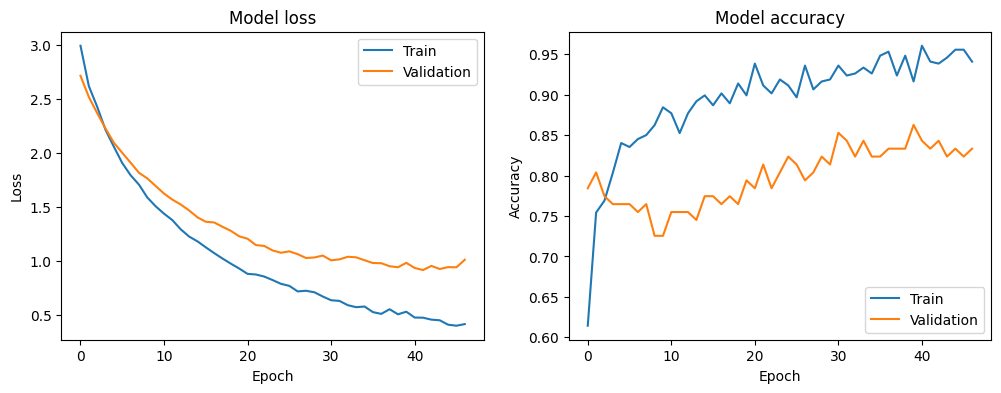

In [17]:
model_regularized = tf.keras.Sequential([
    tf.keras.layers.Input((X_train.shape[1],)),
    tf.keras.layers.Dense(200, activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(200, activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.01)),
     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
model_regularized.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"])
history = model_regularized.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      epochs=100,
                     callbacks=[early_stopping],
                      verbose=0)

plot_history(history)

Here we can see the training accuracy is around 0.95 and validation(test) accuracy is around 0.85

In [18]:
y_pred=model_regularized.predict(X_val)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [19]:
print(roc_auc_score(y_val,y_pred))

0.8615965989607937


## RandomForestClassifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model=RandomForestClassifier(n_estimators=150,random_state=42)
rf_model.fit(X_train,y_train)



RandomForestClassifier(n_estimators=150, random_state=42)

## Result

From the above training results we can see that neural network model has a higher roc-auc score. Hence we will be using that model for testing.

## Testing on TestSet

In [21]:
test_df=pd.read_csv("/kaggle/input/neural-net-nexus/test.csv")
test_df.isna().sum()


Age                        0
HB (gm/dl)                 0
ESR(mm)                    2
WBC(TC) (/cumm)            0
Neutrophils (%)            0
lymphocytes (%)            0
Monocytes (%)              0
Eosinophils (%)            0
Cir Eosinophils (/cumm)    0
RBC (m/ul)                 0
HTC/PCV (%)                0
MCV (fl)                   0
MCH (pg)                   0
MCHC (g/dl)                0
RDW  (%)                   0
PDW (fl)                   1
Platelete(PC)(/cumm)       0
MPV (fl)                   0
PCT (%)                    0
dtype: int64

In [22]:
test_df['ESR(mm)'].fillna(df['ESR(mm)'].mean(),inplace=True)
test_df['PDW (fl)'].fillna(df['PDW (fl)'].mean(),inplace=True)

<ipython-input-22-d367867c7428>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['ESR(mm)'].fillna(df['ESR(mm)'].mean(),inplace=True)
<ipython-input-22-d367867c7428>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [23]:
x_test=test_df.values
print(x_test.shape)
x_test=scaler.transform(x_test)

(100, 19)


In [24]:
y_pred=model_regularized.predict(x_test)
y_pred


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[5.2455873e-03],
       [1.1008963e-02],
       [9.6464716e-03],
       [1.7953651e-02],
       [7.5928196e-03],
       [2.2100680e-02],
       [1.2581631e-02],
       [3.5532459e-05],
       [7.2717763e-02],
       [2.5340421e-02],
       [1.4236601e-04],
       [1.1384805e-02],
       [6.0409736e-02],
       [7.5580818e-03],
       [8.8118284e-04],
       [5.0408381e-01],
       [4.6955124e-02],
       [5.2611860e-03],
       [6.4983354e-03],
       [9.0396899e-04],
       [2.7225222e-02],
       [1.5259378e-04],
       [9.9823344e-03],
       [6.3442858e-04],
       [7.9297192e-02],
       [1.6897896e-02],
       [7.2971664e-02],
       [3.9902274e-02],
       [9.3238981e-04],
       [6.3508637e-02],
       [3.0375892e-02],
       [3.0976962e-02],
       [2.1638060e-02],
       [1.6046403e-02],
       [2.8649464e-02],
       [6.4949284e-04],
       [9.9202693e-02],
       [1.4517725e-01],
       [1.6788179e-02],
       [2.3167247e-02],
       [2.0229718e-02],
       [7.489312

In [25]:
predictions=[]
index=[]
i=0
for item in y_pred:
    if item<.5:
        predictions.append(0)
    else:
        predictions.append(1)
    index.append(i)
    i=i+1
predictions

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [26]:
submission=pd.DataFrame({
    "ID":index,
    "Prediction":y_pred.flatten()
})
print(submission.head(20))
submission.to_csv("submission.csv",index=False)

    ID  Prediction
0    0    0.005246
1    1    0.011009
2    2    0.009646
3    3    0.017954
4    4    0.007593
5    5    0.022101
6    6    0.012582
7    7    0.000036
8    8    0.072718
9    9    0.025340
10  10    0.000142
11  11    0.011385
12  12    0.060410
13  13    0.007558
14  14    0.000881
15  15    0.504084
16  16    0.046955
17  17    0.005261
18  18    0.006498
19  19    0.000904
